In [25]:

from pathlib import Path
import json
from collections import Counter, defaultdict
from PIL import Image
from tqdm import tqdm

# >>>> EDIT THESE TWO LINES TO MATCH YOUR MACHINE <<<<
PROJECT_ROOT = Path(".")  # or r"C:\path\to\PROJET_TUTEURÉ"
DATA_DIR = PROJECT_ROOT / "data"

# Inputs (from your screenshot)
IMG_DIR = DATA_DIR / "PadChest_GR"
JSON_IN = DATA_DIR / "grounded_reports_20240819 (1).json"  # rename here if your file name differs

# Output COCO file
COCO_OUT = DATA_DIR / "dataset_coco.json"

print("Images dir:", IMG_DIR.resolve())
print("JSON in   :", JSON_IN.resolve())
print("COCO out  :", COCO_OUT.resolve())


Images dir: D:\Projects\projet_tuteuré\data\PadChest_GR
JSON in   : D:\Projects\projet_tuteuré\data\grounded_reports_20240819 (1).json
COCO out  : D:\Projects\projet_tuteuré\data\dataset_coco.json


In [26]:
with open(JSON_IN, "r", encoding="utf-8") as f:
    data = json.load(f)

n_images = len(data)
n_images_with_boxes = 0
total_boxes = 0
label_ctr = Counter()

for rec in data:
    has_box = False
    for fnd in rec.get("findings", []):
        boxes = fnd.get("boxes", []) or []
        if boxes:
            has_box = True
            total_boxes += len(boxes)
            for lab in fnd.get("labels", []) or []:
                label_ctr[lab.strip()] += 1
    if has_box:
        n_images_with_boxes += 1

print(f"Total records: {n_images}")
print(f"Images with >=1 box: {n_images_with_boxes}")
print(f"Total GT boxes (ONLY 'boxes'): {total_boxes}")
print("Top labels:", label_ctr.most_common(15))


Total records: 4555
Images with >=1 box: 3008
Total GT boxes (ONLY 'boxes'): 7733
Top labels: [('cardiomegaly', 494), ('aortic elongation', 463), ('scoliosis', 376), ('vertebral degenerative changes', 248), ('aortic atheromatosis', 242), ('pleural effusion', 203), ('apical pleural thickening', 191), ('vascular hilar enlargement', 187), ('costophrenic angle blunting', 182), ('interstitial pattern', 180), ('air trapping', 173), ('chronic changes', 151), ('laminar atelectasis', 147), ('alveolar pattern', 144), ('infiltrates', 143)]


In [27]:
def load_image_size(image_path: Path):
    """
    Returns (W, H) for a single image, or (None, None) if the file can't be opened.
    """
    try:
        with Image.open(image_path) as im:
            return im.width, im.height  # PIL exposes width/height reliably
    except Exception:
        return None, None

def to_pixel_bbox(norm_xyxy, W, H):
    """
    Convert normalized [x_min, y_min, x_max, y_max] in [0,1] to COCO [x, y, w, h] in pixels.
    """
    x1, y1, x2, y2 = norm_xyxy
    x1_px, y1_px = max(0.0, x1 * W), max(0.0, y1 * H)
    x2_px, y2_px = min(float(W), x2 * W), min(float(H), y2 * H)
    w, h = max(0.0, x2_px - x1_px), max(0.0, y2_px - y1_px)
    return [float(x1_px), float(y1_px), float(w), float(h)]


In [28]:
def convert_to_coco(
    json_file: Path,
    img_dir: Path,
    out_file: Path,
    drop_images_without_boxes: bool = True,
    image_exts=(".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
):
    data = json.loads(Path(json_file).read_text(encoding="utf-8"))

    # 1) Build categories from labels that appear alongside real boxes
    label_set = set()
    for rec in data:
        for fnd in rec.get("findings", []):
            boxes = fnd.get("boxes", []) or []
            if boxes:
                for lab in fnd.get("labels", []) or []:
                    if lab is not None:
                        label_set.add(lab.strip())

    categories = [{"id": i + 1, "name": name} for i, name in enumerate(sorted(label_set))]
    cat_to_id = {c["name"]: c["id"] for c in categories}

    images, annotations = [], []
    ann_id = 1

    def find_image_path(image_id_str: str):
        """
        Try several filename patterns to find the actual file on disk.
        Your JSON seems to store something like '..._wigcpj.png' as ImageID,
        or (sometimes) without extension. We handle both.
        """
        # If ImageID already has an extension:
        p = img_dir / image_id_str
        if p.exists():
            return p

        # Try appending common extensions:
        for ext in image_exts:
            p2 = img_dir / f"{image_id_str}{ext}"
            if p2.exists():
                return p2
        return None

    for rec in tqdm(data, desc="Converting"):
        image_id_str = rec.get("ImageID")
        img_path = find_image_path(image_id_str)

        record_boxes = []
        record_labels = []

        # Only take 'boxes' (skip any 'extra_boxes')
        for fnd in rec.get("findings", []):
            boxes = fnd.get("boxes", []) or []
            if not boxes:
                continue

            # If multiple labels exist for a finding, assign the first one by default
            labs = fnd.get("labels", []) or []
            label_for_boxes = labs[0].strip() if labs else None
            for b in boxes:
                record_boxes.append(b)
                record_labels.append(label_for_boxes)

        if drop_images_without_boxes and not record_boxes:
            continue

        # If we do have boxes, we need the true pixel size
        if record_boxes and (img_path is None):
            # Can't compute pixel bboxes without width/height; skip to keep COCO valid
            continue

        W, H = load_image_size(img_path) if img_path else (None, None)
        if record_boxes and (W is None or H is None):
            # Could not read the image (corrupt or path mismatch) → skip
            continue

        # Create image entry
        img_id = len(images) + 1
        images.append({
            "id": img_id,
            "file_name": img_path.name if img_path else image_id_str,
            "width": int(W) if W else 0,
            "height": int(H) if H else 0
        })

        # Create annotations
        for b_norm, lab in zip(record_boxes, record_labels):
            if lab not in cat_to_id:
                # if a box had no label, skip it (or map to a fallback if you prefer)
                continue
            bbox = to_pixel_bbox(b_norm, W, H)
            area = float(bbox[2] * bbox[3])
            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cat_to_id[lab],
                "bbox": bbox,          # [x, y, w, h] in pixels (COCO)
                "area": area,
                "iscrowd": 0,
                "segmentation": []
            })
            ann_id += 1

    coco = {
        "info": {
            "description": "Converted from grounded_reports JSON (boxes only)",
            "version": "1.0"
        },
        "licenses": [],
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    out_file.write_text(json.dumps(coco, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"COCO saved to: {out_file}")
    print(f"Images: {len(images)} | Annotations: {len(annotations)} | Categories: {len(categories)}")

# --- Run it ---
convert_to_coco(JSON_IN, IMG_DIR, COCO_OUT, drop_images_without_boxes=True)


Converting: 100%|██████████| 4555/4555 [00:00<00:00, 9198.91it/s]


COCO saved to: data\dataset_coco.json
Images: 3008 | Annotations: 7733 | Categories: 151


In [29]:
coco = json.loads(COCO_OUT.read_text(encoding="utf-8"))
print("IMAGES (first 2):")
print(json.dumps(coco["images"][:2], indent=2)[:1000], "...\n")
print("ANNOTATIONS (first 3):")
print(json.dumps(coco["annotations"][:3], indent=2)[:1000], "...\n")
print("CATEGORIES (first 10):")
print(json.dumps(coco["categories"][:10], indent=2))


IMAGES (first 2):
[
  {
    "id": 1,
    "file_name": "251488034557732338959601580328898734705_wigcpj.png",
    "width": 1824,
    "height": 1652
  },
  {
    "id": 2,
    "file_name": "312447841912476392836878255221324752437_m4dphn.png",
    "width": 3000,
    "height": 2904
  }
] ...

ANNOTATIONS (first 3):
[
  {
    "id": 1,
    "image_id": 1,
    "category_id": 15,
    "bbox": [
      504.71446176,
      172.47296304,
      380.27169696000004,
      141.30314267999998
    ],
    "area": 53733.5858527046,
    "iscrowd": 0,
    "segmentation": []
  },
  {
    "id": 2,
    "image_id": 1,
    "category_id": 15,
    "bbox": [
      1007.58741312,
      147.53711336,
      392.73963072000004,
      187.01885608
    ],
    "area": 73449.71647453604,
    "iscrowd": 0,
    "segmentation": []
  },
  {
    "id": 3,
    "image_id": 2,
    "category_id": 96,
    "bbox": [
      1048.98057,
      1688.8235232000002,
      384.14517,
      458.11764503999984
    ],
    "area": 175983.6806338904,


Shape: (1652, 1824) dtype: float32


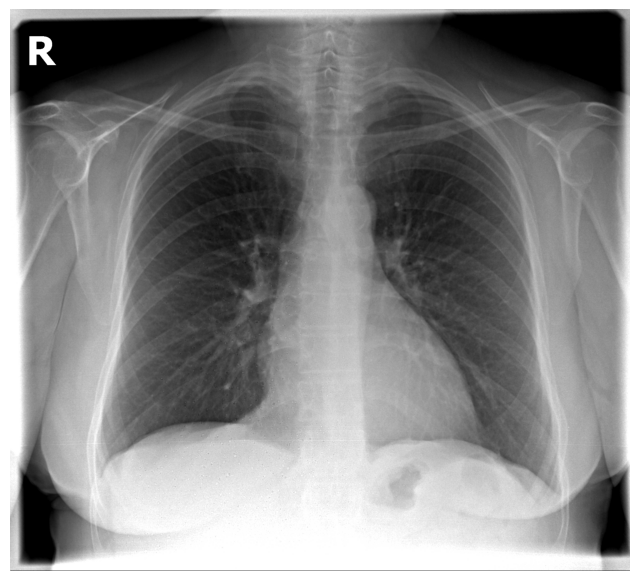

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = "data/PadChest_GR/251488034557732338959601580328898734705_wigcpj.png"

# Read the image directly
img = mpimg.imread(img_path)

print("Shape:", img.shape, "dtype:", img.dtype)

plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray")   # force grayscale colormap
plt.axis("off")
plt.show()


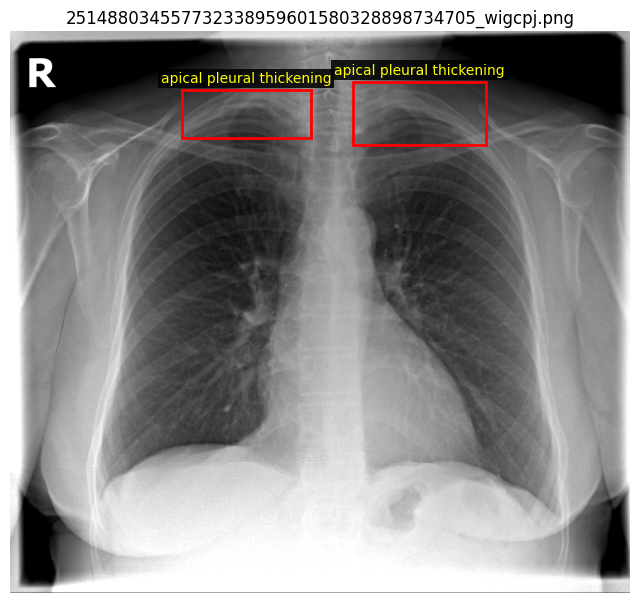

In [40]:
# --- Plot X-ray + COCO-style boxes with labels centered above the box ---
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# >>> EDIT THESE PATHS <<<
IMG_DIR = Path("data/PadChest_GR")
JSON_PATH = Path("data/grounded_reports_20240819 (1).json")

# Build lookup: ImageID (filename) -> list[(bbox_norm, label)]
def load_boxes(json_path: Path):
    with open(json_path, "r", encoding="utf-8") as f:
        records = json.load(f)

    per_image = {}
    for rec in records:
        image_id = rec.get("ImageID")  # expected to match your filename (e.g., foo.png)
        for fnd in rec.get("findings", []) or []:
            boxes = fnd.get("boxes", []) or []          # <-- ONLY 'boxes'
            labels = fnd.get("labels", []) or []
            label = labels[0].strip() if labels else ""
            for b in boxes:
                per_image.setdefault(image_id, []).append((b, label))
    return per_image

def plot_image_with_boxes(
    img_path: Path,
    per_image_boxes: dict,
    label_offset_px: int = 12,         # vertical gap between box and label
    linewidth: float = 2.0
):
    # Read the image directly with matplotlib
    img = mpimg.imread(img_path)
    # Support grayscale or RGB; shape can be (H,W) or (H,W,C)
    H, W = img.shape[0], img.shape[1]

    fig, ax = plt.subplots(figsize=(8, 8))
    # Force grayscale colormap for consistent medical look
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(img_path.name)

    # Draw boxes for this image (normalized coords -> pixel coords)
    for (x1, y1, x2, y2), label in per_image_boxes.get(img_path.name, []):
        # Pixel box
        x = x1 * W
        y = y1 * H
        w = (x2 - x1) * W
        h = (y2 - y1) * H

        # Rectangle
        rect = patches.Rectangle(
            (x, y), w, h, fill=False, linewidth=linewidth, edgecolor="r"
        )
        ax.add_patch(rect)

        # Label centered above the box
        # y_pos a bit above the top edge; clamp to keep it visible
        y_pos = max(5, y - label_offset_px)
        x_center = x + w / 2.0
        ax.text(
            x_center,
            y_pos,
            label if label else "",
            fontsize=10,
            color="yellow",
            ha="center",
            va="bottom",
            bbox=dict(facecolor="black", alpha=0.85, pad=2, edgecolor="none"),
            clip_on=False,  # let it show even near the top border
        )

    plt.show()

# ---------- Example usage ----------
per_image_boxes = load_boxes(JSON_PATH)

# Choose any filename that exists in data/PadChest_GR
filename = "251488034557732338959601580328898734705_wigcpj.png"
plot_image_with_boxes(IMG_DIR / filename, per_image_boxes, label_offset_px=14)
